# Grokking with a simple model on modular addition

## 0. Preliminaries

Imports and set the CUDA device

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA       # Needed for PCA of embeddings
import os
import wandb

wandb.login()

D_EMBED = 128
HIDDEN = 256
# Prime number for modular addition
P = 53
SEED = 42
TRAIN_FRACTION = 0.5
BATCH_SIZE = 64
NB_EPOCHS = 1400
LEARNING_RATE = 0.0003
WEIGHT_DECAY = 1
SHARP_PENALTY = 100.0


run = wandb.init(project="sharpness-as-regularization-grokking-jupyter",
                config={"prime_number": P,
                        "learning_rate": LEARNING_RATE,
                        "train_fraction": TRAIN_FRACTION,
                        "batch_size": BATCH_SIZE,
                        "nb_epochs": NB_EPOCHS,
                        "weight_decay": WEIGHT_DECAY,
                        "sharp_penalty": SHARP_PENALTY,
                        "hidden": HIDDEN,
                        "embed": D_EMBED,
                        "seed": SEED})

# Define time scales
wandb.define_metric("step")
wandb.define_metric("epoch")

# Define metrics
wandb.define_metric("training/accuracy", step_metric='epoch')
wandb.define_metric("training/loss", step_metric='epoch')
wandb.define_metric("validation/accuracy", step_metric='epoch')
wandb.define_metric("validation/loss", step_metric='epoch')
wandb.define_metric("training/sharpness", step_metric='epoch')
wandb.define_metric("validation/sharpness", step_metric='epoch')

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    print("Using GPU", torch.cuda.get_device_name(0))
else:
    print("Using CPU")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zlxie (zlxiepku). Use `wandb login --relogin` to force relogin


Using GPU NVIDIA GeForce RTX 4090


Set seed everywhere for reproducibility

In [2]:
def set_seed(seed_value=0):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

## 1. Building the dataset
Define the dataset : addition modulo P, with a random split into train and test sets, and dataloaders with batch size

In [3]:
# Create the dataset
set_seed(SEED)
data = []
for i in range(P):
    for j in range(P):
        data.append([i,j,(i+j)%P])
data = np.array(data)

# Split into train and test
np.random.shuffle(data)
train_data = data[:int(len(data) * TRAIN_FRACTION)]
test_data = data[int(len(data) * TRAIN_FRACTION):]

# Convert to tensors and create dataloaders with batch size
train_data = torch.tensor(train_data, dtype=torch.long, device=device)
test_data = torch.tensor(test_data, dtype=torch.long, device=device)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## 2. Model definition
A linear embedding layer followed by concatenation of the two (embedded) tokens, and a simple FF with one hidden layer.

In [4]:


class EmbeddingConcatFFModel(nn.Module):
    def __init__(self):
        super(EmbeddingConcatFFModel, self).__init__()
        self.embed = nn.Embedding(P, D_EMBED)
        self.linear1 = nn.Linear(2 * D_EMBED, HIDDEN)   # 2 * D_EMBED because we concatenate the two embedded tokens
        self.linear2 = nn.Linear(HIDDEN, P)
        self.init_weights()
        
    def forward(self, X):
        x1, x2 = X[:,0], X[:,1]
        x1 = self.embed(x1)
        x2 = self.embed(x2)
        x = torch.cat((x1, x2), dim=1)  # Concatenate the embedding of the two tokens
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    
    # Weight initialization
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                nn.init.xavier_normal_(m.weight)               
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

In [5]:
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from scipy.sparse.linalg import LinearOperator, eigsh
from torch import Tensor
import copy


def lanczos(matrix_vector, dim: int, neigs: int=6):
    """ Invoke the Lanczos algorithm to compute the leading eigenvalues and eigenvectors of a matrix / linear operator
    (which we can access via matrix-vector products). """

    def mv(vec: np.ndarray):
        gpu_vec = torch.tensor(vec, dtype=torch.float).cuda()
        return matrix_vector(gpu_vec)

    operator = LinearOperator((dim, dim), matvec=mv)
    evals, evecs = eigsh(operator, neigs)
    return torch.from_numpy(np.ascontiguousarray(evals[::-1]).copy()).float(), \
           torch.from_numpy(np.ascontiguousarray(np.flip(evecs, -1)).copy()).float()


def get_hessian_eigenvalues(network: nn.Module, loss_fn: nn.Module,
                            X: Tensor, y: Tensor, neigs: int=6):
    """ Compute the leading Hessian eigenvalues. """
    hvp_delta = lambda delta: compute_hvp(network, loss_fn, X, y, delta).detach().cpu()
    nparams = len(parameters_to_vector((network.parameters())))
    evals, evecs = lanczos(hvp_delta, nparams, neigs=neigs)
    return evals, evecs


def compute_hvp(network: nn.Module, loss_fn: nn.Module, X: Tensor, y: Tensor, vector: Tensor):
    """Compute a Hessian-vector product."""
    p = len(parameters_to_vector(network.parameters()))
    n = len(y)
    hvp = torch.zeros(p, dtype=torch.float, device='cuda')
    vector = vector.cuda()
    # for (X, y) in iterate_dataset(dataset, physical_batch_size):
    loss = loss_fn(network(X), y) / n
    # print(loss.grad_fn)
    # for param in network.parameters():
    #     print(param.requires_grad)
    grads = torch.autograd.grad(loss, inputs=network.parameters(), create_graph=True)
    dot = parameters_to_vector(grads).mul(vector).sum()
    grads = [g.contiguous() for g in torch.autograd.grad(dot, network.parameters(), retain_graph=True)]
    hvp += parameters_to_vector(grads)
    return hvp

def get_hessian_eigenvalues_pow(network: nn.Module, loss_fn: nn.Module,
                                X: Tensor, y: Tensor, num_iterations: int=1,
                                neigs: int=6, tol: float=1e-6):
    v = torch.randn(len(parameters_to_vector(network.parameters())), dtype=torch.float, device='cuda')
    largest_eigenvalue_old = 0.0
    for _ in range(num_iterations):
        with torch.enable_grad():
            Hv = compute_hvp(network, loss_fn, X, y, v)
        v = Hv / torch.norm(Hv)
        largest_eigenvalue = v @ Hv
        # Check for convergence
        if torch.abs(largest_eigenvalue - largest_eigenvalue_old) < tol:
            break

        largest_eigenvalue_old = largest_eigenvalue.clone()
    return largest_eigenvalue, v

class HessianLargestEigenvalue(torch.autograd.Function):
    @staticmethod
    def forward(ctx, params_vec, network: nn.Module, loss_fn: nn.Module,
                X: Tensor, y: Tensor, neigs: int=1) -> torch.Tensor:
        # Compute the largest eigenvalue using power iteration method
        # vector_to_parameters(params_vec, network.parameters())

        cloned_network = copy.deepcopy(network)
        cloned_params = params_vec.clone().detach()
        vector_to_parameters(cloned_params, cloned_network.parameters())
        with torch.enable_grad():
            evals, evecs = get_hessian_eigenvalues_pow(cloned_network, loss_fn, X, y)

        # Save input and eigenvector for backward pass
        ctx.save_for_backward(evals, evecs, parameters_to_vector(network.parameters()))
        ctx.network = network
        ctx.loss_fn = loss_fn
        ctx.X = X
        ctx.y = y

        return evals

    @staticmethod
    def backward(ctx, grad_output):
        evals, evec, parameters = ctx.saved_tensors
        # evec = evecs[:,0]
        network = ctx.network
        loss_fn = ctx.loss_fn
        X = ctx.X
        y = ctx.y

        p = len(parameters_to_vector(network.parameters()))
        n = len(y)
        d3fv2 = torch.zeros(p, dtype=torch.float, device='cuda')
        vector = evec.cuda()
        # for (X, y) in iterate_dataset(dataset, physical_batch_size):
        with torch.enable_grad():
            loss = loss_fn(network(X), y) / n
            grads = torch.autograd.grad(loss, inputs=network.parameters(), create_graph=True)
            dot = parameters_to_vector(grads).mul(vector).sum()
            grads = torch.autograd.grad(dot, network.parameters(), create_graph=True)
            dot = parameters_to_vector(grads).mul(vector).sum()
            if dot.grad_fn == None:
                grads = torch.zeros_like(parameters_to_vector(grads))
            else:
                grads = torch.autograd.grad(dot, network.parameters(), retain_graph=True)

        return grad_output * parameters_to_vector(grads), None, None, None, None, None

def Lambda(params_dict, network: nn.Module, loss_fn: nn.Module, X: Tensor, y: Tensor) -> torch.Tensor:
    return HessianLargestEigenvalue.apply(params_dict, network, loss_fn, X, y) # type: ignore


In [6]:

# batch = next(iter(train_loader))

# model = EmbeddingConcatFFModel().to(device)
# # model.train()
# # parameters = model.parameters()
# # print(model.state_dict())

# X, y = batch[:,:2], batch[:,2]
# criterion = nn.CrossEntropyLoss()

# # import torch.nn as nn

# class TestFunction(nn.Module):
#     def __init__(self, x, y):
#         super(TestFunction, self).__init__()
#         self.x = torch.nn.Parameter(x)
#         self.y = torch.nn.Parameter(y)

#     def forward(self, X):
#         return self.x**4 + self.y**2.3

# x1 = torch.tensor([1.0], requires_grad=True)
# x2 = torch.tensor([2.0], requires_grad=True)
# y = torch.tensor([1.0], dtype=torch.float, device=device)
# model = TestFunction(x1, x2).to(device)

# criterion = lambda x, y: x

# # X = torch.tensor([[1, 2], [3, 4]], dtype=torch.float, device=device)
# # y = torch.tensor([1, 2], dtype=torch.float, device=device)

# # largeEval = HessianLargestEigenvalue()
# params_vector = parameters_to_vector(model.parameters())
# # vector_to_parameters(params_vector, model.parameters())
# # evals, evecs = get_hessian_eigenvalues(model, criterion, X, y)
# # for param in model.parameters():
# #     param.requires_grad = True
# # params_vector = torch.zeros([])

# # bigeval = HessianLargestEigenvalue.apply(params_vector, model, criterion, X, y)
# bigeval = Lambda(params_vector, model, criterion, X, y)

# bigeval.backward()

# print(bigeval)
# for name, param in model.named_parameters():
#     print(name, param.grad)model = EmbeddingConcatFFModel().to(device)
# parameters = model.parameters()
# # print(model.state_dict())

# X, y = batch[:,:2], batch[:,2]
# criterion = nn.CrossEntropyLoss()

# # evals, evecs = get_hessian_eigenvalues(model, criterion, X, y)
# # largeEval = HessianLargestEigenvalue()
# params_vector = parameters_to_vector(model.parameters()).detach().requires_grad_(True)
# for param in model.parameters():
#     param.requires_grad = True

# bigeval = Lambda(params_vector, model, criterion, X, y)
# # print(bigeval)

# # print(evals[0])
# hvp = compute_hvp(model, criterion, X, y, evecs[:,0])
# # hvp.backward()
# # print(hvp)
# # evals[0].backward()


## 3. Training
We use AdamW with weight decay, and cross entropy loss

In [7]:
set_seed(SEED)
model = EmbeddingConcatFFModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# Recording
REPORT_INTERVAL = 20    # How often we print
SAVE_INTERVAL = 50      # How often we save
model_folder = 'intermediary'
# Create folder if it doesn't exist
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(NB_EPOCHS):
    
    # Training phase
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    train_sharpness = 0.0
    for batch in train_loader:
        X, y = batch[:,:2], batch[:,2]
        optimizer.zero_grad()
        output = model(X)
        if SHARP_PENALTY >= 1e-4:
            sharpness = Lambda(parameters_to_vector(model.parameters()), model, criterion, X, y)
            loss = criterion(output, y) + SHARP_PENALTY * sharpness
        else:
            with torch.no_grad():
                sharpness = Lambda(parameters_to_vector(model.parameters()), model, criterion, X, y)
            loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == y).sum().item()
        train_sharpness += sharpness.item()
        
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    train_acc /= len(train_data)
    train_acc_history.append(train_acc)
    train_sharpness /= len(train_loader)

    wandb.log({"training/accuracy": train_acc, "training/loss": train_loss, "training/sharpness": train_sharpness, "epoch": epoch})
    # Testing phase
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        test_sharpness = 0.0
        for batch in test_loader:
            X, y = batch[:,:2], batch[:,2]
            output = model(X)
            sharpness = Lambda(parameters_to_vector(model.parameters()), model, criterion, X, y)
            loss = criterion(output, y) + SHARP_PENALTY * sharpness
            # loss = criterion(output, y)
            test_loss += loss.item()
            test_acc += (output.argmax(dim=1) == y).sum().item()
            test_sharpness += sharpness.item()
        
        test_loss /= len(test_loader)
        test_loss_history.append(test_loss)
        test_acc /= len(test_data)
        test_acc_history.append(test_acc)
        test_sharpness /= len(test_loader)

        wandb.log({"validation/accuracy": test_acc, "validation/loss": test_loss, "validation/sharpness": test_sharpness})

    if epoch % REPORT_INTERVAL == 0:
        # print(loss.item(), train_sharpness, "\n")
        print(f"{epoch}/{NB_EPOCHS}: Train loss={train_loss:.4f}, acc={100*train_acc:.1f}%  /  Test loss={test_loss:.4f}, acc={100*test_acc:.1f}%")
    
    if epoch % SAVE_INTERVAL == 0:
        # Save model in intermediary folder
        torch.save(model.state_dict(), f"{model_folder}/model_{epoch}.pth")

torch.save(model.state_dict(), f"model.pth")

0/1400: Train loss=11.8277, acc=1.4%  /  Test loss=11.7546, acc=1.8%
20/1400: Train loss=11.7790, acc=15.6%  /  Test loss=12.3233, acc=0.0%
40/1400: Train loss=12.7948, acc=23.0%  /  Test loss=14.3077, acc=0.0%
60/1400: Train loss=13.7354, acc=36.1%  /  Test loss=16.7344, acc=0.0%
80/1400: Train loss=14.2987, acc=51.6%  /  Test loss=18.7838, acc=0.0%
100/1400: Train loss=14.5944, acc=70.1%  /  Test loss=20.2841, acc=0.0%
120/1400: Train loss=14.6499, acc=85.0%  /  Test loss=21.4041, acc=0.0%
140/1400: Train loss=14.7854, acc=93.5%  /  Test loss=22.1648, acc=0.0%
160/1400: Train loss=14.5758, acc=97.3%  /  Test loss=22.7397, acc=0.0%
180/1400: Train loss=14.3601, acc=98.8%  /  Test loss=23.1928, acc=0.0%
200/1400: Train loss=14.1641, acc=99.5%  /  Test loss=23.4269, acc=0.0%
220/1400: Train loss=13.7994, acc=99.8%  /  Test loss=23.5854, acc=0.0%
240/1400: Train loss=13.6075, acc=100.0%  /  Test loss=23.7075, acc=0.0%
260/1400: Train loss=13.4061, acc=100.0%  /  Test loss=23.6891, acc=0.

## 4. Results

Plot the evolution of accuracy and loss during training

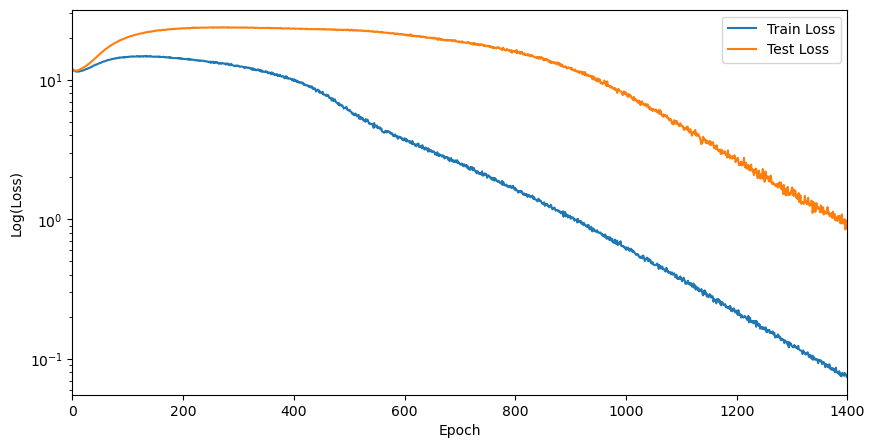

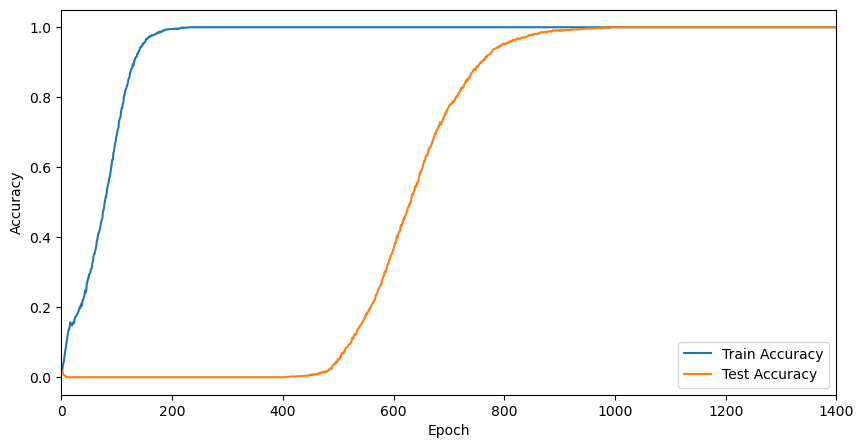

In [8]:
NB_EPOCH_PLOT = 1400

# Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, NB_EPOCHS + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, NB_EPOCHS + 1), test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Log(Loss)')
plt.yscale('log')
plt.legend()
plt.savefig('loss.png', dpi=300)
plt.xlim(0,NB_EPOCH_PLOT)
plt.savefig('loss_zoom.png', dpi=300)


# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, NB_EPOCHS + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, NB_EPOCHS + 1), test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png', dpi=300)
plt.xlim(0,NB_EPOCH_PLOT)
plt.savefig('accuracy_zoom.png', dpi=300)

### Principal Component Analysis of the embeddings

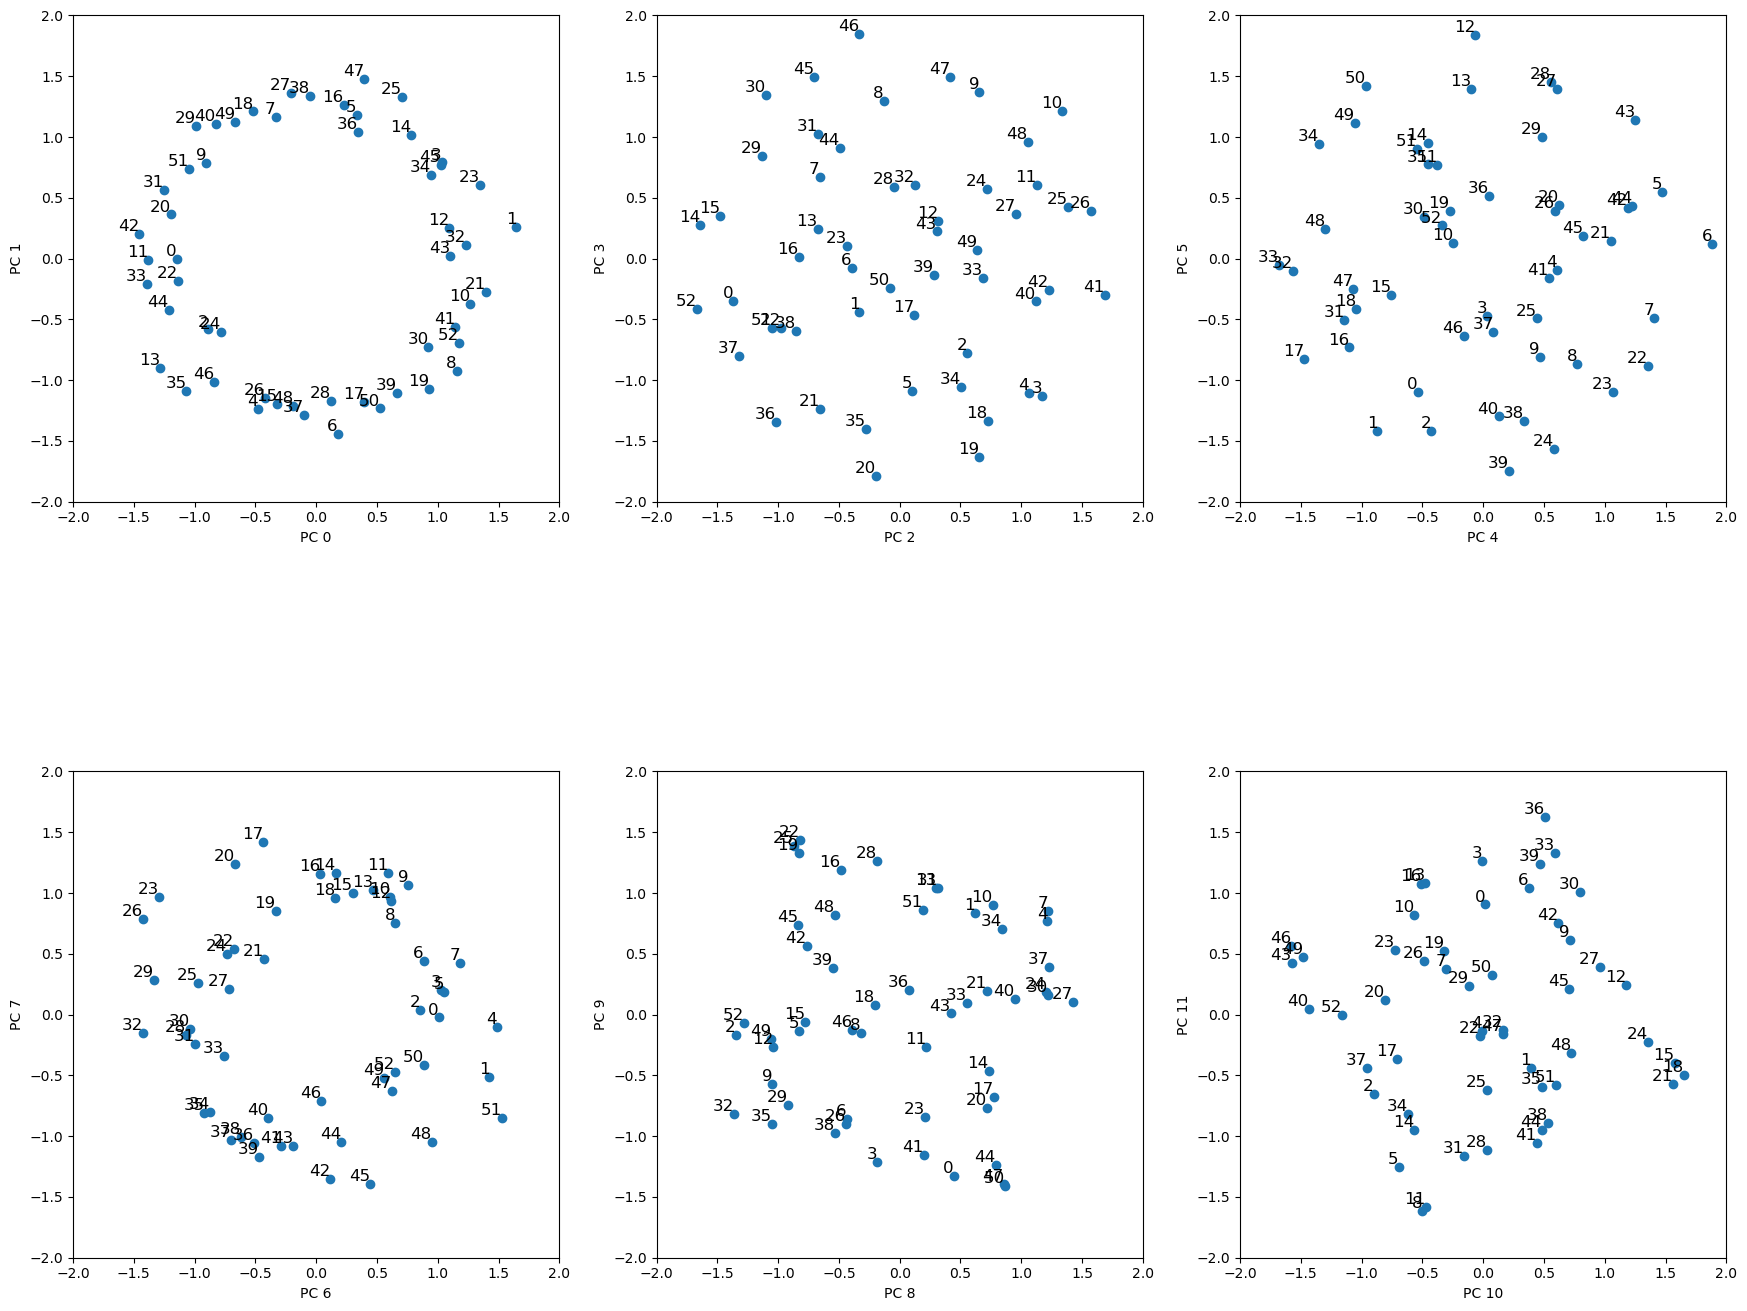

In [9]:
# Extract embeddings
model.load_state_dict(torch.load(f"model.pth"))
model.eval()
with torch.no_grad():
    embeddings = model.embed(torch.arange(0, P).to(device)).cpu().numpy()

# PCA
NB_COMPONENTS = 12
pca = PCA(n_components=NB_COMPONENTS)
embeddings_pca = pca.fit_transform(embeddings)

# Plot
ny = int(np.floor(np.sqrt(16/9 * NB_COMPONENTS // 2)))
nx = int(np.ceil((NB_COMPONENTS //2) / ny))

plt.figure(figsize=(16/9 * 6 * nx, 6 * ny))
for n in range(NB_COMPONENTS // 2):
    plt.subplot(nx, ny, n + 1)
    plt.scatter(embeddings_pca[:, 2 * n + 0], embeddings_pca[:, 2 * n + 1], marker='o')
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.gca().set_aspect('equal')

    # Annotate each point on the scatter plot
    for i, (x, y) in enumerate(embeddings_pca[:, (2 * n + 0):(2 * n + 2)]):
        plt.text(x, y, str(i), fontsize=12, ha='right', va='bottom')
        
    plt.xlabel(f"PC {2 * n + 0}")
    plt.ylabel(f"PC {2 * n + 1}")

plt.savefig('pca.png', dpi=300)

Follow the evolution of the embeddings during training projected on the principal components found before

MovieWriter ffmpeg unavailable; using Pillow instead.


0
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350


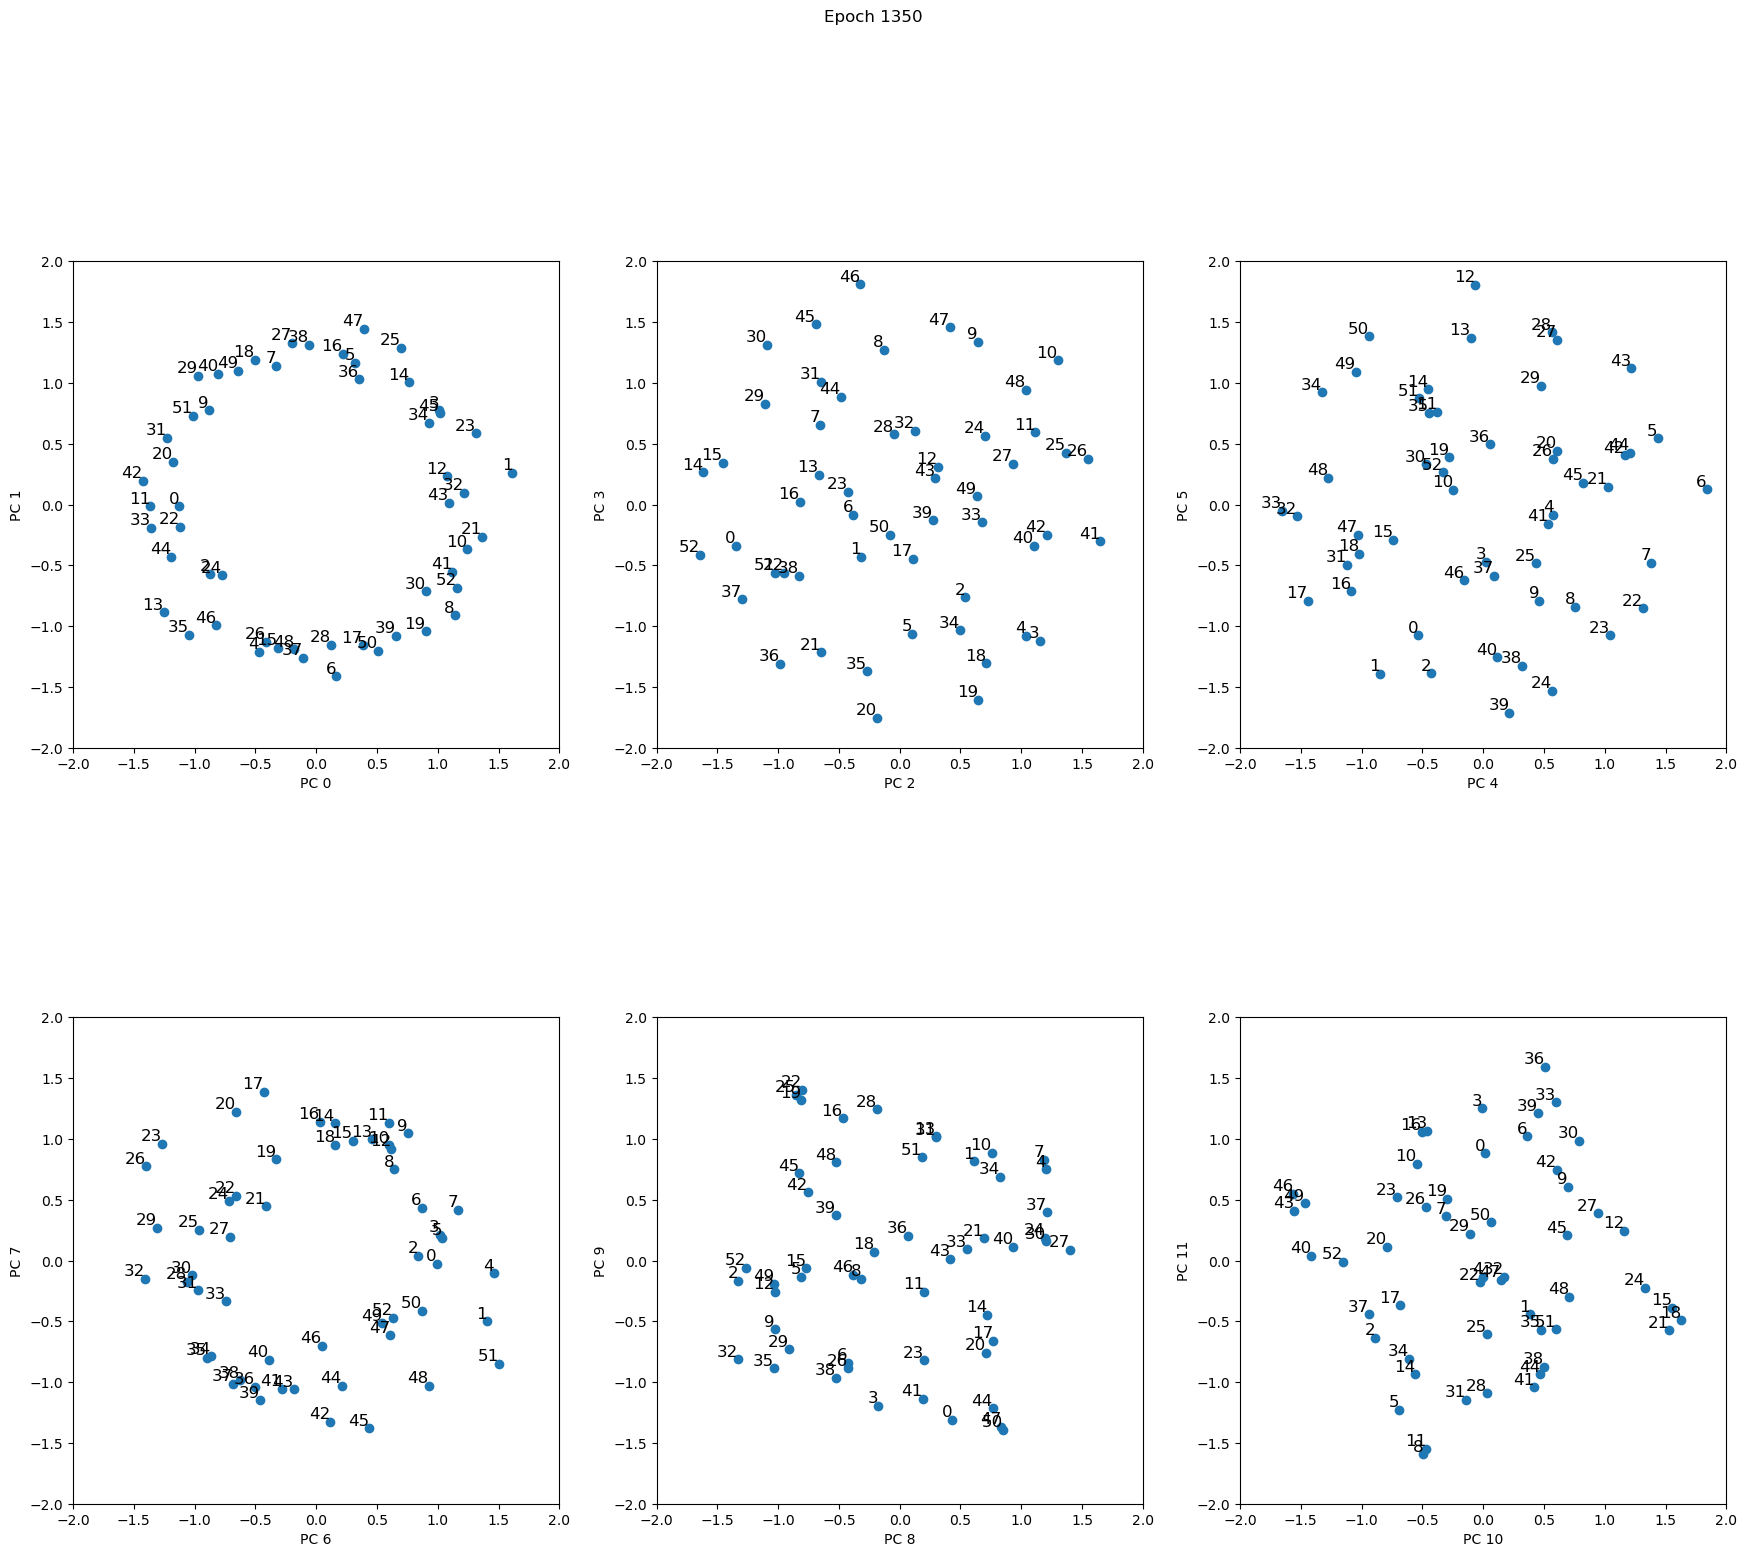

In [10]:
from matplotlib.animation import FuncAnimation

# Plot
ny = int(np.floor(np.sqrt(16/9 * NB_COMPONENTS // 2)))
nx = int(np.ceil((NB_COMPONENTS //2) / ny))

fig, axes = plt.subplots(nx, ny, figsize=(16/9 * 6 * nx, 6 * ny))

def update(epoch):
    print(epoch)
    model.load_state_dict(torch.load(f"{model_folder}/model_{epoch}.pth"))
    model.eval()
    with torch.no_grad():
        embeddings = model.embed(torch.arange(0, P).to(device)).cpu().numpy()
    embeddings_pca = pca.transform(embeddings)

    for n, ax in enumerate(axes.flatten()):
        ax.clear()
        ax.scatter(embeddings_pca[:, 2 * n], embeddings_pca[:, 2 * n + 1], marker='o')
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_aspect('equal')

        for i, (x, y) in enumerate(embeddings_pca[:, (2 * n):(2 * n + 2)]):
            ax.text(x, y, str(i), fontsize=12, ha='right', va='bottom')
        
        ax.set_xlabel(f"PC {2 * n}")
        ax.set_ylabel(f"PC {2 * n + 1}")

    plt.suptitle(f"Epoch {epoch}")

# Create animation
ani = FuncAnimation(fig, update, frames=range(0, NB_EPOCHS, SAVE_INTERVAL), blit=False)

# Save animation
ani.save('pca_evolution.gif', writer='ffmpeg')

plt.show()

In [11]:
if wandb.run is not None:
    wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training/accuracy,▁▂▄▆████████████████████████████████████
training/loss,▇▇█████▇▇▇▆▆▅▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training/sharpness,▅▆▇█████▇▇▇▆▆▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▅▆▇▇██████████████████
validation/loss,▄▅▆▇███████████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁
validation/sharpness,▄▅▆▆▇▇▇▇▇▇█████████▇▇▇▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁
epoch,1399
training/accuracy,1.0
training/loss,0.07611
training/sharpness,0.00075
